In [19]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.utils as Utils
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import linalg
import mplhep as hep
#from models import GraphNet
plt.style.use(hep.style.CMS)

In [2]:
class GraphNet(nn.Module):
    def __init__(self, input_dim = 12, hidden_dim = 64, output_dim = 1, aggr = 'add', niters = 4):
        super(GraphNet, self).__init__()
        
        # transform to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
#             nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2*hidden_dim, hidden_dim),
#             nn.ReLU()
        )
        
        # to compute messages
        convnetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        
        # edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.niters = niters
    
    def forward(self, data):
        X = data.x
        #print(f"edges {data.num_edges}")
        #print(f"initial X size {X.size()}")
        H = self.inputnetwork(X)
        #print(f"size after inputnet {H.size()}")
        for i in range(self.niters):
            (prepared_edges, _) = Utils.add_self_loops(data.edge_index)
            H = self.graphconv(H, Utils.to_undirected(prepared_edges))
            #print(f"size of H after {i}th iter {H.size()}")
            
        src, dst = data.edge_index
        #print(f"src size {H[src].size()} dest size {H[dst].size()}")
        #print(f"torch cat {torch.cat([H[src], H[dst]], dim=-1).size()}")
        #print(f"GraphNet returns {self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1).size()}")
        #print(f"score size {(H[src] * H[dst]).sum(dim=-1)}")
        #return (H[src] * H[dst]).sum(dim=-1)
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [3]:
def plotTrackster2D(fig, ax2, y, z, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)', proj = None):
    fs = 16
    for ind in edges:
        if(ind not in edges_t):
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0] ,y[idx1]],
                [z[idx0] ,z[idx1]],
                'red', lw = 0.5, label = "Wrong Edges"
            )
        else:
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0], y[idx1]],
                [z[idx0] ,z[idx1]],
                'black', lw = 0.5, label = "Correct Edges"
            )
    for t_ind in edges_t:
        if(t_ind not in edges):
            if len(t_ind) == 0:
                continue
#             for ied in ind:
            idx0 = t_ind[0]
            idx1 = t_ind[1]
            ax2.plot(
                [y[idx0] ,y[idx1]],
                [z[idx0] ,z[idx1]],
                'blue', lw = 0.5, label = "Missed Edges"
            )
    yg = ax2.scatter(y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
    ax2.tick_params(axis='x', labelsize=fs )
    ax2.tick_params(axis='y', labelsize=fs )
    ax2.set_xlabel(proj[0] + " cm", fontsize = fs)
    ax2.set_ylabel(proj[1] + " cm", fontsize = fs)

In [4]:
  
def plotTrackster3D(fig, ax, x, y, z, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    fs = 15
    print(x[0],y[0],z[0])
    ax.set_xlabel('Z (cm)', fontsize = fs)
    ax.set_ylabel('X (cm)', fontsize = fs)
    ax.set_zlabel('Y (cm)', fontsize = fs)
    colmap = cm.ScalarMappable(cmap=cm.viridis)
    if len(heatmap) > 0:
        for ind in edges:
            if(ind not in edges_t):
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'red', lw = 0.5, label = "Wrong Edges"
                )
            else:
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'black', lw = 0.5, label = "Correct Edges"
                )
        for t_ind in edges_t:
            if(t_ind not in edges):
                if len(t_ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = t_ind[0]
                idx1 = t_ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'blue', lw = 0.5, label = "Missed Edges"
                )
    if len(heatmap) > 0 :
        colmap.set_array(heatmap)
        yg = ax.scatter(x, y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
        cb = fig.colorbar(colmap,label=label)
    else:
        yg =ax.scatter(x, y, z, marker='o')     
    ax.tick_params(axis='x', labelsize=fs )
    ax.tick_params(axis='y', labelsize=fs )
    ax.tick_params(axis='z', labelsize=fs )



In [5]:
from matplotlib.lines import Line2D
def plotTrackster(fig, ax,ax2,ax3,ax4, x, y, z, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    plotTrackster3D(fig, ax, x,y,z, heatmap=E,edges=p_pairs, edges_t = t_pairs )
    ## XY
    plotTrackster2D(fig, ax2 ,y, z,heatmap=E,edges=p_pairs, edges_t = t_pairs, proj=["X", "Y"])
    ## XZ
    plotTrackster2D(fig, ax3 ,y, x,heatmap=E,edges=p_pairs, edges_t = t_pairs, proj=["X", "Z"])
    ## YZ
    plotTrackster2D(fig, ax4 ,z, x,heatmap=E,edges=p_pairs, edges_t = t_pairs, proj=["Y", "Z"])
    custom_lines = [Line2D([0], [0], color='red',lw = 4),
                    Line2D([0], [0], color='black', lw=4),
                   Line2D([0], [0], color='blue', lw=4)]
    ax.legend(custom_lines, ['Wrong Edges', 'Correct Edges', "Missed Edges"], fontsize=15)

    plt.show()

In [6]:
# test dataset is not normalized before storing on disk
# as the mean_ and scale_ are required for the 
# inverse transformation
def normalize_and_get_data(data_list, ev):
    data_list_ev = data_list[ev]
    x_np = data_list_ev[0]
    x_coord_slice = x_np[:, [0,1,2]]
    x_rest_slice = x_np[:, [9,10,11]]
    
    mean = []
    std = []
    scaler=StandardScaler()
    scaler.fit(x_coord_slice)
    x_coord_norm = scaler.transform(x_coord_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean.append(np.zeros(6)) # for the unnormalized features
    std.append(np.ones(6))
    
    scaler.fit(x_rest_slice)
    x_rest_norm = scaler.transform(x_rest_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean = np.concatenate(mean, axis=-1)
    std = np.concatenate(std, axis=-1)
    
    x_ev = torch.from_numpy(np.concatenate((x_coord_norm, x_np[:,[3,4,5,6,7,8]], x_rest_norm), axis=1))
    edge_label = torch.from_numpy(data_list_ev[1])
    edge_index = torch.from_numpy(data_list_ev[2])
    data = Data(x=x_ev, num_nodes=torch.tensor(x_ev.shape[0]), edge_index=edge_index, edge_label=edge_label)
    return data, mean, std
    
def truth_pairs(model, data_list, ev, thr=0.5):
    data_ev, mean, std = normalize_and_get_data(data_list, ev)
    truth_edge_index = data_ev.edge_index
    truth_edge_label = data_ev.edge_label > thr
    truth_nodes_features = torch.add(torch.mul(data_ev.x, torch.from_numpy(std)),torch.from_numpy(mean))
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]

    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i], dest_edge_index_true[i]])
    return truth_nodes_features, index_tuple

def prediction_pairs(model, data_list, ev, thr):
    data_ev, mean, std = normalize_and_get_data(data_list, ev)
    out = model(data_ev)
    truth_edge_index = data_ev.edge_index
    truth_edge_label = out > thr
    truth_nodes_features = torch.add(torch.mul(data_ev.x, torch.from_numpy(std)),torch.from_numpy(mean)) #denormalize
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]
    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i], dest_edge_index_true[i]])

    
    return truth_nodes_features,index_tuple 

def connectivity_matrix(model, data_list, ev, similarity=True, thr=0.7):
    data_ev, mean, std = normalize_and_get_data(data_list, ev)
    out = model(data_ev)
    N = data_ev.num_nodes
    mat = np.zeros([N, N])
    truth_mat = np.zeros([N, N])
    for indx, src in enumerate(data_ev.edge_index[0]):
        dest = data_ev.edge_index[1][indx]
        mat[src][dest] = out[indx]
        mat[dest][src] = out[indx]
        truth_mat[src][dest] = data_ev.edge_label[indx]
        truth_mat[dest][src] = data_ev.edge_label[indx]
        
    if similarity == False:
        mat = mat > thr
    return mat, truth_mat

In [7]:
# Load the dataset
#testDataset = torch.load("/eos/user/w/wredjeb/SWAN_projects/GraphSC/HackathonLinking/dataProcessed/dataTest.pt")
testDataset = torch.load("/eos/user/a/abhiriks/SWAN_projects/TICLv4graph/test/HackathonLinking/dataProcessed/dataTest.pt")

In [8]:
# Load the model
modelLoad = GraphNet()
#modelLoad.load_state_dict(torch.load("/eos/user/w/wredjeb/SWAN_projects/GraphSC/HackathonLinking/FirstModel/model.pt")["model_state_dict"])
modelLoad.load_state_dict(torch.load("/eos/user/a/abhiriks/SWAN_projects/TICLv4graph/test/HackathonLinking/model/trackster_graphconv.pt"))
modelLoad.eval()

GraphNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (graphconv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  ))
  (edgenetwork): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

340.2171035482434 -14.532645152504024 -52.47128282023648


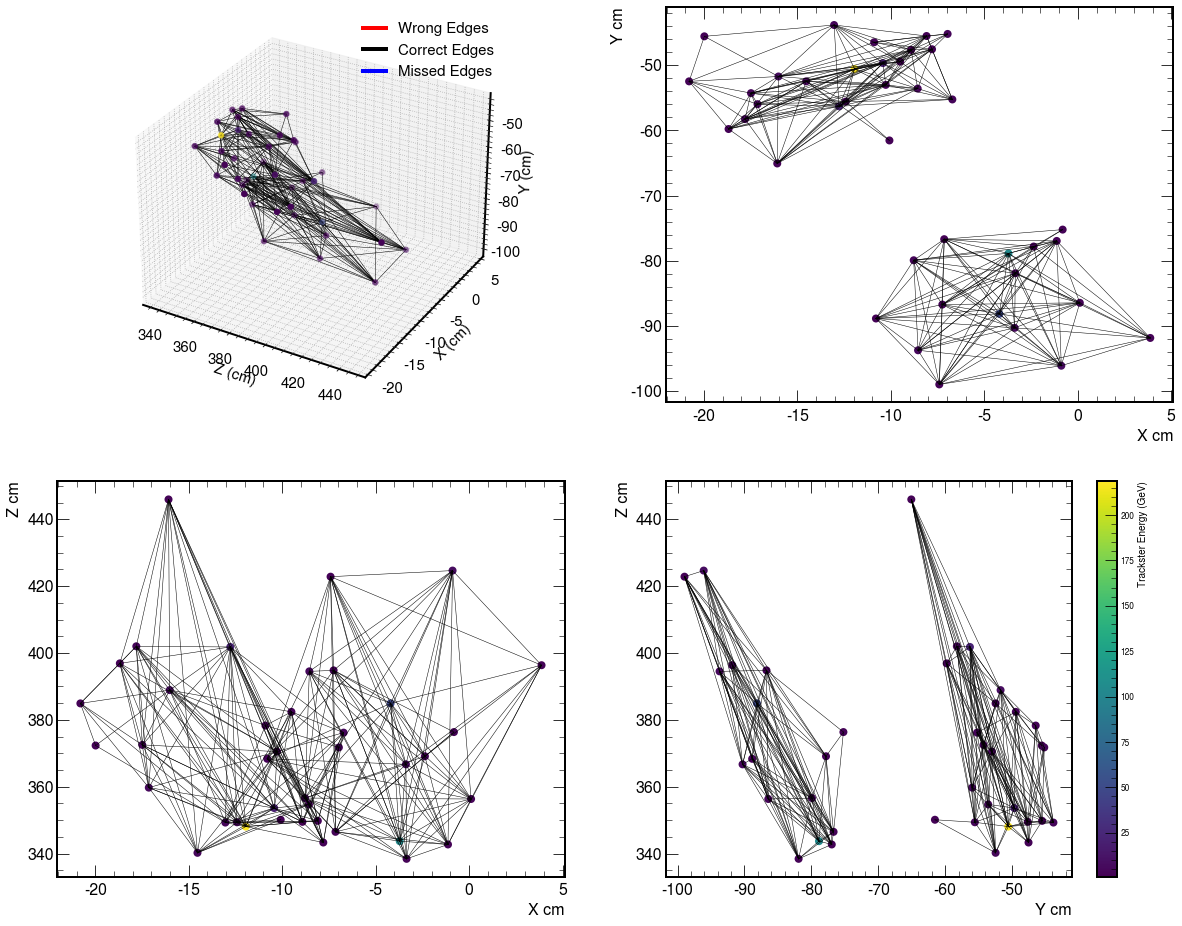

In [9]:
ev_vis = 101 #event to visualize
t_node, t_pairs = truth_pairs(modelLoad, testDataset, ev_vis, 0.5)
p_node, p_pairs = prediction_pairs(modelLoad, testDataset, ev_vis, 0.6)

from pylab import cm
from IPython.display import display

%matplotlib inline
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
x = p_node[:,0].detach().numpy()
y = p_node[:,1].detach().numpy()
z = p_node[:,2].detach().numpy()
E = p_node[:,10].detach().numpy()
plotTrackster(fig, ax, ax2,ax3,ax4, z,x,y,heatmap=E,edges=p_pairs, edges_t = t_pairs)

In [10]:
truth_adj, similarity = connectivity_matrix(modelLoad, testDataset, ev_vis)
adjacency = similarity>0.6

In [11]:
degree = np.sum(adjacency, axis = 1)
weighted_deg = np.sum(similarity, axis = 1)

In [12]:
D = np.diag(degree)
L = D - similarity # Graph Laplacian

In [13]:
eigvals, eigvecs = linalg.eig(L)
keys = np.argsort(eigvals)
eigvecs_sorted = eigvecs[keys]
eigvals_sorted = eigvals[keys]
cluster_labels = np.where(eigvecs_sorted[1] < 0, 0, 1) # eigvec for second lowest eigenval

In [14]:
# from Fiedler vector - eigenvector corresponding to the second lowest eigenvalue
print(f"predicted labels from Fiedler vector : {cluster_labels}")

predicted labels from Fiedler vector : [0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1
 0 0 1]


In [15]:
# Spectral clustering
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters = 2, assign_labels="cluster_qr", affinity="precomputed").fit(similarity)
cluster_labels = clustering.labels_
print(f"predicted labels from spectral clustering : {cluster_labels}")

predicted labels from spectral clustering : [1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1
 0 0 1]


/eos/user/a/abhiriks/.local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [16]:
import networkx as nx
t_edges = []
for p in t_pairs:
    t_edges.append([p[0].item(), p[1].item()])
G = nx.Graph()
G.add_edges_from(t_edges)
G.add_nodes_from(range(len(t_node)))
print(f"number of connected components : {nx.number_connected_components(G)}")
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

truth_cluster_labels = np.zeros(len(t_node))

for i, s in enumerate(S):
    print(s.nodes)
    for n in list(s):
        truth_cluster_labels[n] = i
print(f"truth cluster labels : {truth_cluster_labels}")

number of connected components : 2
[0, 1, 4, 6, 7, 9, 8, 10, 12, 14, 15, 17, 23, 18, 19, 21, 22, 27, 28, 32, 33, 34, 36, 39]
[2, 3, 35, 5, 37, 38, 11, 13, 16, 20, 24, 25, 26, 29, 30, 31]
truth cluster labels : [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.]


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


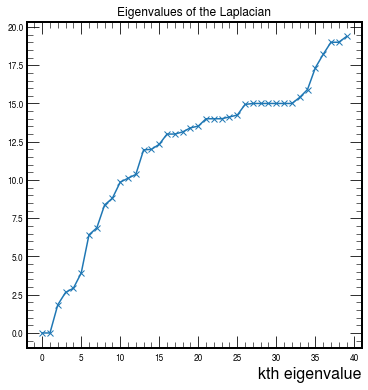

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.plot(eigvals_sorted, marker="x")
ax.set_xlabel("kth eigenvalue", fontsize = 16)
ax.set_title("Eigenvalues of the Laplacian")
plt.show()

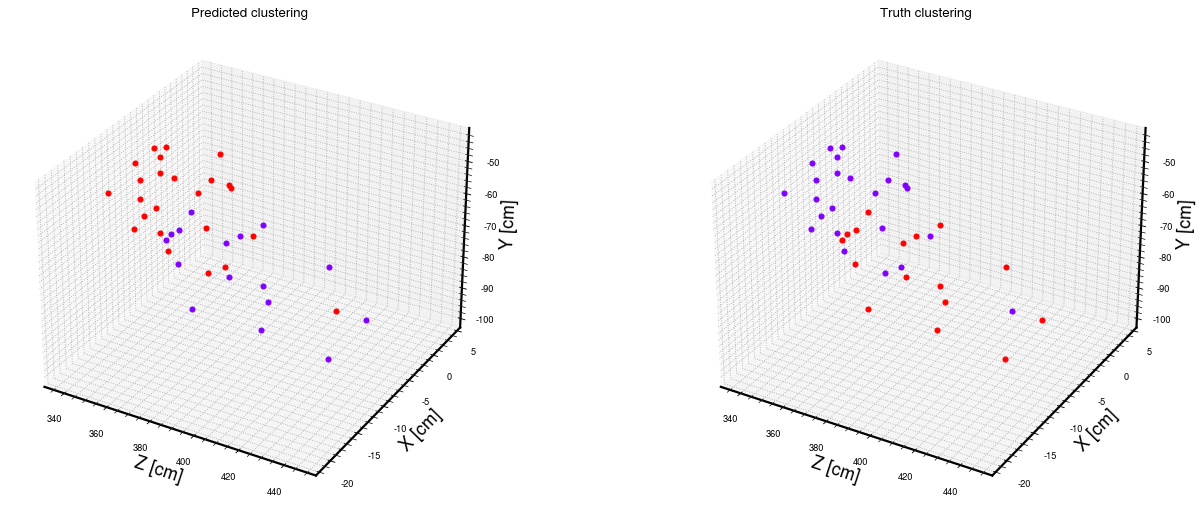

In [18]:
import matplotlib.colors
fig = plt.figure(figsize=(20,8), dpi=80)
ax = fig.add_subplot(121, projection="3d")
ax.set_xlabel("Z [cm]", fontsize = 16)
ax.set_ylabel("X [cm]", fontsize = 16)
ax.set_zlabel("Y [cm]", fontsize = 16)
ax.set_title("Predicted clustering")
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(0, max(cluster_labels))
for i, x_i in enumerate(x):
    ax.scatter(z[i], x_i, y[i], color=cmap(norm(cluster_labels[i])))
ax1 = fig.add_subplot(122, projection="3d")
ax1.set_xlabel("Z [cm]", fontsize = 16)
ax1.set_ylabel("X [cm]", fontsize = 16)
ax1.set_zlabel("Y [cm]", fontsize = 16)
ax1.set_title("Truth clustering")
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(0, max(truth_cluster_labels))
for i, x_i in enumerate(x):
    ax1.scatter(z[i], x_i, y[i], color=cmap(norm(truth_cluster_labels[i])))